# Time Constructions, Part 2

In part 1 of time construction analysis, I used exploratory analysis to find the top major forms amongst time constructions in Biblical Hebrew. That analysis culminated in a tokenization strategy which labeled like-elements within time constructions to obtain raw groups. Those groups were counted, and it was found that out of 312 raw different surface forms, the top 11 attested for 75% of individual instances. These few forms thus encapsulate a majority of the data.

In this notebook, I want to break down the major subcategories of the top surface forms. For instance, the most common token is `prep.time`, i.e. a preposition + a time word. But there are major differences amongst this group. Specifically, the time noun is often specified by a further element. In some cases this further element consists of an infinitival clause that modifies the time noun. Some time nouns are statistically associated with the time function, such as יום, שׁנה etc. But some are not, such as nouns which describe events. These are of a different semantic type.

This analysis will follow a similar strategy as part 1, using a process of elimination to narrow down the primary groups amongst the data. 

In [220]:
import collections, csv, random
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from pyscripts.significance import contingency_table, apply_fishers
from tf.fabric import Fabric
from tf.app import use

custom_data = ['/Users/cody/text-fabric-data/etcbc/bhsa/tf/c',
               '/Users/cody/github/etcbc/heads/tf/c',
               '../data/test/',
               '../data/funct_associations/'
              ]

TF = Fabric(locations=custom_data)
api = TF.load('''

vs vt pdp gloss lex language 
rela typ number function prs
g_cons_utf8 lex_utf8 nu mother st uvf
head nhead obj_prep sem_set
ls topAssoc TimeAssoc LocaAssoc
label role
''')

A = use('bhsa', api=api, hoist=globals(), silent=True)

A.displaySetup(condenseType='clause', condensed=True, withNodes=True)

This is Text-Fabric 7.4.11
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

141 features found and 3 ignored
  0.00s loading features ...
   |     0.20s B g_cons_utf8          from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.15s B lex                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.22s B lex_utf8             from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B vs                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B vt                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.16s B pdp                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.17s B gloss                from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B language             from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.24s B rela                 from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.32s B typ                  from /Users

# Helper Functions

In [222]:
def convert2pandas(counterdict):
    '''
    Converts a counter dict to a sorted Pandas DF
    '''
    return pd.DataFrame.from_dict(counterdict, orient='index', columns=['sum']).sort_values(by='sum', ascending=False)

    
def reverse_hb(hb_text):
    '''
    Reverses Hebrew text for plotting.
    '''
    return ''.join(reversed(hb_text))

def countBarplot(count_df, 
                 title='', 
                 column='sum', 
                 reverse_labels=False, 
                 size=(8, 6),
                 xlab_rotation=None,
                ):
    '''
    Makes simple barplot from collections.Counter type objects.
    '''
    n_bars = list(range(0, count_df.shape[0]))
    x_labels = [''.join(reversed(prep)) for prep in count_df.index] if reverse_labels else count_df.index
    plt.figure(figsize=size)
    sns.barplot(n_bars, count_df[column], color='darkblue')
    plt.xticks(n_bars, x_labels, size=18, rotation=xlab_rotation)
    plt.yticks(size=18)
    plt.title(title, size=18,  y=1.05)
    plt.ylabel(column, size=18)
    plt.show()

# Helper Data

In [3]:
label2result = collections.defaultdict(list)
for cx in F.otype.s('construction'):
    label2result[F.label.v(cx)].append(L.d(cx, 'phrase'))

# Time Constructions: Their Distribution and Make-Up

This analysis repeats some parts of previous studies, [SBH_time_expressions](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/SBH_time_expressions.ipynb) and [duratives](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/duratives.ipynb), but now with the new time construction data and for all known time constructions in the Hebrew Bible.

## Time Construction Distribution and Selectivity

### Distribution of Time Constructions Across Corpus

In [4]:
strip_data = []
covered_chapters = set()
bookboundaries = {}

twelve = ('Hosea', 'Joel', 'Amos', 'Obadiah',
          'Jonah', 'Micah', 'Nahum', 'Habakkuk',
          'Zephaniah', 'Haggai', 'Zechariah',
          'Malachi')

# map grouped book names
megilloth = ('Ruth', 'Lamentations', 'Ecclesiastes', 'Esther', 'Song_of_songs')
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
for book in twelve: book_map[book] = 'Twelve'
for book in megilloth: book_map[book] = 'Megilloth'
for book in ('Ezra', 'Nehemiah', 'Daniel'): book_map[book] = 'Daniel-Neh'

    
# iterate through constructions and gather book data
this_book = None

for cx in F.otype.s('construction'):
    chapter_node = L.u(cx, 'chapter')[0]
    book, chapter, verse = T.sectionFromNode(cx)
    this_book = book_map.get(book, book)
    covered_chapters.add(chapter_node)
    chapter_label = len(covered_chapters)
    
    if this_book not in bookboundaries: # add first chapter to boundaries for plotting
        bookboundaries[this_book] = chapter_label
    
    strip_data.append(chapter_label)

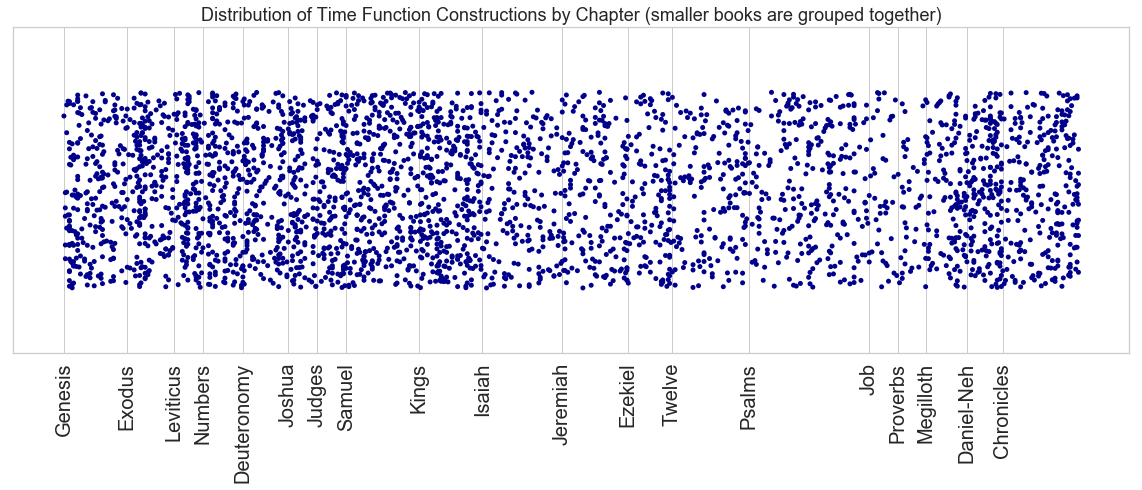

In [159]:
strip_title = 'Distribution of Time Function Constructions by Chapter (smaller books are grouped together)'
plt.figure(figsize=(20, Cody6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue').set_title(strip_title)
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.show()

### Degree of Dispersion Compared to Other Functions

The strip chart gives a good sense of how spread out time constructions are in the Hebrew Bible. We can also see that the distribution is sparser throughout the poetics books, from Isaiah until the beginning of Daniel-Nehemiah. This variation in density can be quantified using a statistical measure known as **degree of dispersion** (Gries, S. 2008. "Dispersions and Adjusted Frequencies in Corpora"). We can use this measure to compare the time construction against other functions in corpus.

In [6]:
# count all phrase tokens per book
phrase_functions = collections.defaultdict(lambda:collections.Counter())

functionmap = {'PreO': 'Pred', 'PreS': 'Pred', 'PtcO': 'Pred', # collect some of the idiosyncratic BHSA functions
              'IntS': 'Intj', 'NCoS': 'NCop','ModS': 'Modi',
              'ExsS': 'Exst'}

for phrase in F.otype.s('phrase'):
    book, chapter, verse = T.sectionFromNode(phrase)
    book = book_map.get(book, book)
    # use constructional phrases only for Time function phrases
    # some time phrases are excluded, others follow a primary time phrase
    # ignore excluded TPs and secondary TPs
    if F.function.v(phrase) == 'Time':
        time_cx = L.u(phrase, 'construction')[0] if L.u(phrase, 'construction') else tuple()
        if not time_cx: # excluded TP
            continue
        elif list(L.d(time_cx, 'phrase')).index(phrase) == 0:
            phrase_functions[book]['Time'] += 1

    # count all other function types
    else:
        funct = functionmap.get(F.function.v(phrase), F.function.v(phrase))
        phrase_functions[book][funct] += 1
    
    
phrase_functions = pd.DataFrame(phrase_functions).fillna(0)

The BHSA has some idiosyncatic functions that only occur a handfull of times relative to the whole corpus. See especially those below that fall below a frequency of 300:

In [7]:
phrase_functions.sum(1)

Adju     9509.0
Cmpl    30035.0
Conj    46153.0
EPPr       22.0
Exst      157.0
Frnt     1137.0
Intj     1872.0
Loca     2623.0
Modi     3773.0
NCop      698.0
Nega     6044.0
Objc    22667.0
PrAd      246.0
PrcS        8.0
PreC    19395.0
Pred    63523.0
Ques     1200.0
Rela     6328.0
Subj    31952.0
Supp      178.0
Time     3376.0
Voct     1607.0
dtype: float64

I've decided to remove these marginal forms from the analysis by selecting only those that occur total > 300 times. The new functions are seen below.

In [8]:
phrase_functions = phrase_functions[phrase_functions.sum(1) > 300]

phrase_functions.sum(1).sort_values(ascending=False)

Pred    63523.0
Conj    46153.0
Subj    31952.0
Cmpl    30035.0
Objc    22667.0
PreC    19395.0
Adju     9509.0
Rela     6328.0
Nega     6044.0
Modi     3773.0
Time     3376.0
Loca     2623.0
Intj     1872.0
Voct     1607.0
Ques     1200.0
Frnt     1137.0
NCop      698.0
dtype: float64

In [123]:
expected_prop = phrase_functions.sum() / phrase_functions.sum().sum()
observed_prop = phrase_functions.div(phrase_functions.sum(1), axis=0)
prop_diffs = abs(expected_prop-observed_prop)
dp = prop_diffs.sum(1) / 2
dp = pd.DataFrame(dp, columns=['DP']).sort_values(by='DP') # DP score finalized here
dp

,DP
Pred,0.031140
Subj,0.044646
Conj,0.055870
Cmpl,0.056796
Objc,0.059706
Time,0.085578
PreC,0.089512
Loca,0.126604
Modi,0.135056
Nega,0.147648


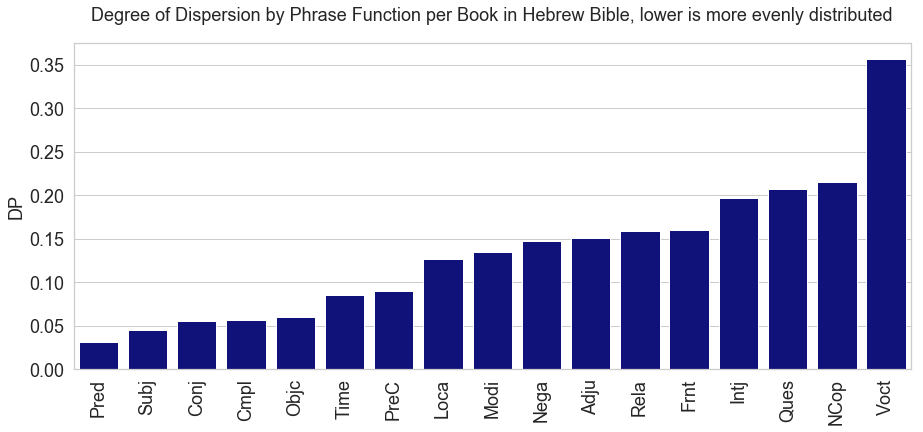

In [124]:
title = 'Degree of Dispersion by Phrase Function per Book in Hebrew Bible, lower is more evenly distributed'
countBarplot(dp, column='DP', title=title, size=(15, 6), xlab_rotation='vertical')

It is significant here that the time construction is more consistently spread than the regular Adjunct function. Its spread relative to Location is harder to evaluate due to the presence of some Location functioning phrases residing in the Complement function. The BHSA labels many locative phrases as simple complements to movement verbs without providing a further distinction that they are likewise locative in nature. That is a shortcoming to the data. This data does tell us, however, that the Time function is more evenly spread than the generic adjunct function, and certainly it is more evenly distributed than Vocative or Question phrases.

We observed in the stripplot that the Time function appeared to be less attested in the books ranging from Isaiah through the end of the Megilloth. 

**Presented below is the difference in proportion, per book, between the expected proportion and the actual observed proportion of Time phrases**. They are sorted from greatest to least, with a higher value indicating that the Time function is under-represented in relation to the size of the book.

In [32]:
prop_diffs_book = pd.DataFrame((observed_prop-expected_prop).loc['Time'].sort_values(ascending=False))
prop_diffs_book.columns = ['difference']

prop_diffs_book

,difference
Kings,0.010557
Deuteronomy,0.010037
Joshua,0.009893
Samuel,0.009189
Leviticus,0.007896
Daniel-Neh,0.007579
Exodus,0.006934
Psalms,0.006885
Judges,0.006865
Chronicles,0.004251


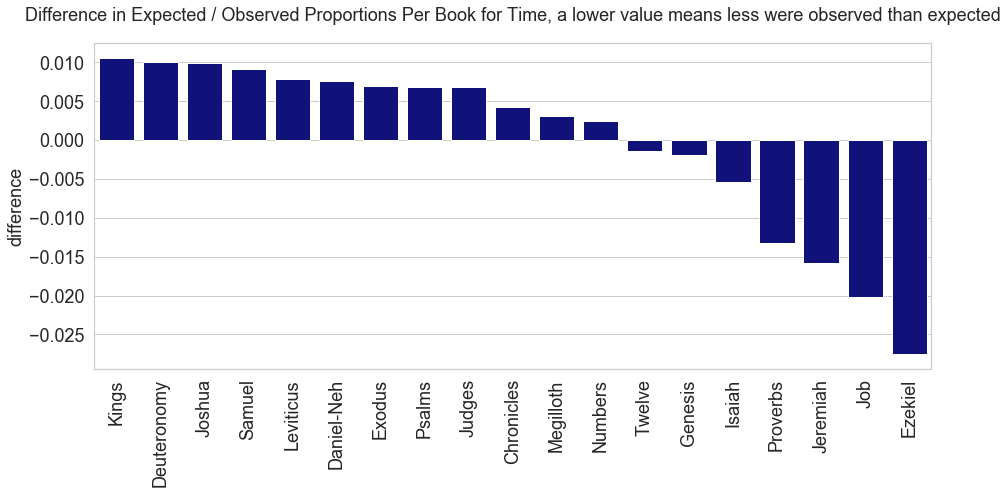

In [33]:
title = 'Difference in Expected / Observed Proportions Per Book for Time, a lower value means less were observed than expected'
countBarplot(prop_diffs_book, column='difference', title=title, size=(15, 6), xlab_rotation='vertical')

As expected from observing the strippchart, poetic books like Ezekiel, Job, Jeremiah, Proverbs, and Isaiah contain less than expected frequencies of Time function. The inclusion of Genesis in this group is surprising, although the barplot helps to see that the difference from Isaiah to Ezekiel is proportionately large. Likewise surprising is the difference in spread between Kings and Chronicles.

I am a bit curious how these differences compare with other kinds of functions. Let's look at the `Pred` function, the function that is said to be the most distributed.

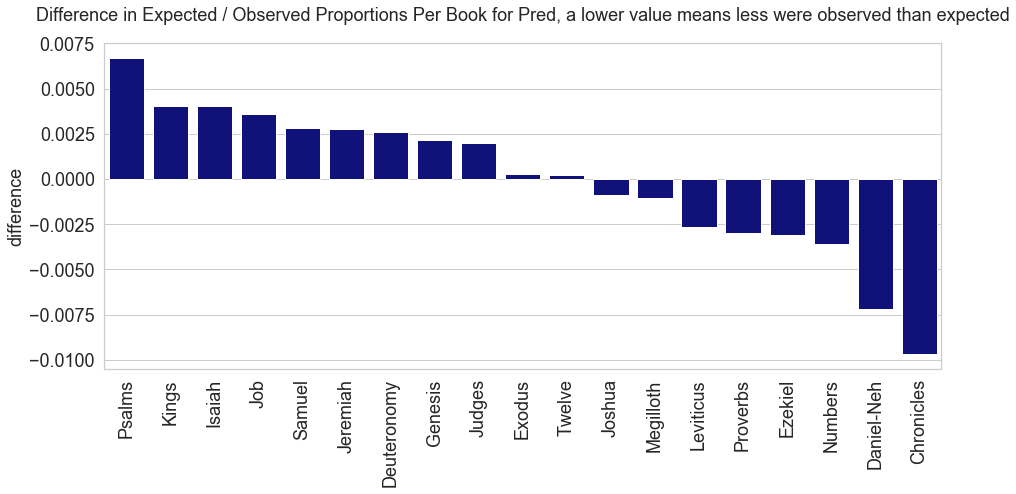

In [34]:
prop_diffs_book_PRED = pd.DataFrame((observed_prop-expected_prop).loc['Pred'].sort_values(ascending=False))
prop_diffs_book_PRED.columns = ['difference']
title = 'Difference in Expected / Observed Proportions Per Book for Pred, a lower value means less were observed than expected'
countBarplot(prop_diffs_book_PRED, column='difference', title=title, size=(15, 6), xlab_rotation='vertical')

It is very interesting that Chronicles and Daniel-Nehemiah are less verbal than expected, while Psalms is more so! To put it another way, relative to all other books in the corpus, Chronicles and Daniel-Nehemiah have a lower distribution of predicate phrases relative to the total number of phrases they contain.

### Excursus: Why is Pred so underpresented in Chronicles?

To answer this question, let's find the function which is most OVER-represented in the book...

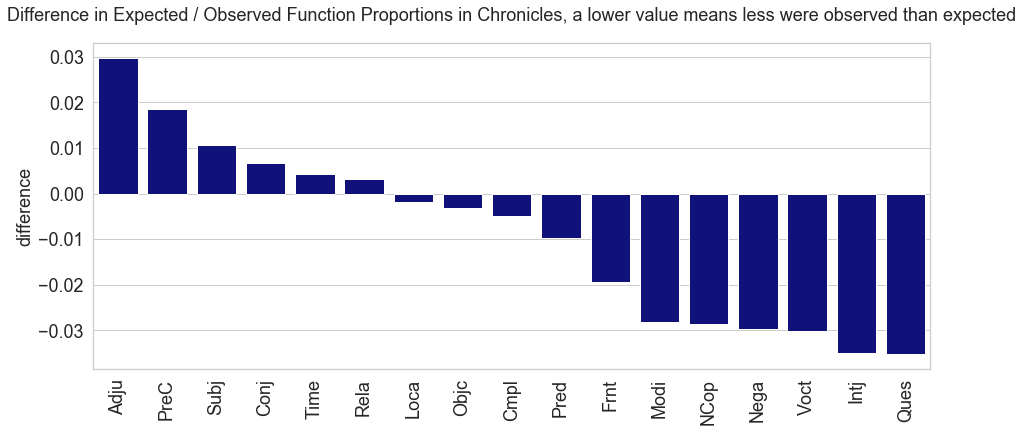

In [56]:
title = 'Difference in Expected / Observed Function Proportions in Chronicles, a lower value means less were observed than expected'
diff_all = observed_prop - expected_prop
chronicles_diffs = pd.DataFrame(diff_all['Chronicles'].sort_values(ascending=False))
chronicles_diffs.columns = ['difference']
countBarplot(chronicles_diffs, title=title, column='difference', size=(15, 6), xlab_rotation='vertical')

The PreC seems like a possible candidate explanation...To find out for sure we could do a count of nominal clauses between all books, and see if Chronicles has a higher than expected proportion. But for now we will be satisfied with this.

### Examine Variety within the Head Lexemes of Phrases with Various Functions

I want to know how the Time phrase compares with other phrase functions in terms of the diversity of its head lexemes. In other words, does the Time function have a wide variety of terms that it regularly uses, or is it more highly selective of key terms? If the latter is true, it could show that time nouns are specialized in their use. Note that for this test, I do not look at lexical heads, but semantic heads. So, for instance, for a prepositional phrase I do not take the preposition but rather the object of the preposition. 

After making a count of all head lexeme/function co-ocurrences, I will normalize the number of lexemes per 100 uses of each function. The normalization is adapted from the helpful explanation of the [grammar lab](http://www.thegrammarlab.com/?p=160). I've adapted it by replacing "word counts" with "lexeme counts" and "corpus size" with "frequency of function." The frequency of all functions is calculated by simply taking the sum of the co-occurrence function counts.

In [104]:
# make a co-occurrence matrix of function columns and co-occurring head lexeme rows

function_heads = collections.defaultdict(lambda: collections.Counter())

for ph in F.otype.s('phrase'):
    
    if not E.head.t(ph): # it should have a head
        continue
    
    function = functionmap.get(F.function.v(ph), F.function.v(ph))
    
    if function in {'Exst', 'EPPr'}:
        continue
    
    for head in E.nhead.t(ph):
        function_heads[function][F.lex.v(head)] += 1
        
function_heads = pd.DataFrame(function_heads).fillna(0)

Make the normalizations...

In [105]:
function_to_lexs = dict((funct, (function_heads[function_heads[funct] > 0]).shape[0]) for funct in function_heads)
function_to_lexs = pd.DataFrame.from_dict(function_to_lexs, orient='index')
function_to_lexs = function_to_lexs[(function_to_lexs > 2).all(1)]

In [106]:
norm_fs_lex = function_to_lexs*100
norm_fs_lex = norm_fs_lex.div(function_heads.sum(), axis='rows')
norm_fs_lex = norm_fs_lex.sort_values(by=0, ascending=False).dropna()

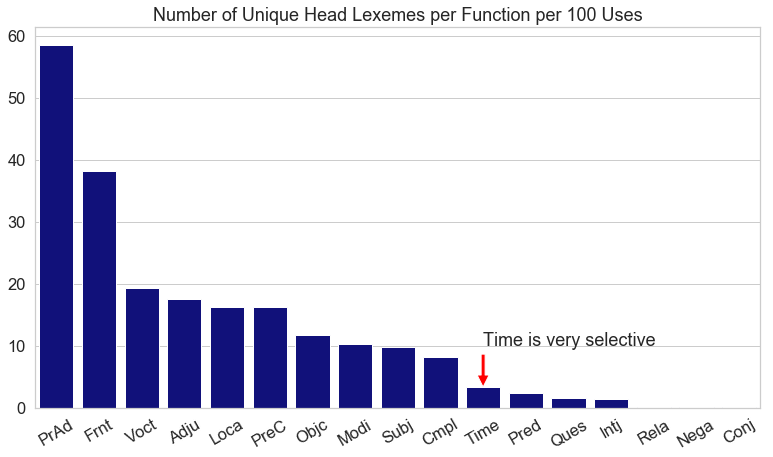

,0
PrAd,58.555133
Frnt,38.255034
Voct,19.285714
Adju,17.563306
Loca,16.294160
PreC,16.169913
Objc,11.790107
Modi,10.343035
Subj,9.820010
Cmpl,8.126475


In [110]:
plt.figure(figsize=(13, 7))
sns.barplot(data=norm_fs_lex.transpose(), color='darkblue')
plt.xticks(rotation=30)
plt.title('Number of Unique Head Lexemes per Function per 100 Uses')
plt.annotate('Time is very selective', xy=(10, 3), xytext=(10, 10), arrowprops=dict(facecolor='red', shrink=0.05), size=18)
plt.show()
display(norm_fs_lex)

## The Make-Up of Time Constructions

Beginning with their phrase types, I will analyze the kind of time constructions found in the corpus.

### Phrase Types Reflected in Constructions

`PP` is prepotional phrase, `NP` is noun phrase, `AdvP` is adverb phrase, as might be expected.

In [64]:
cx_types = collections.Counter()

for cx in F.otype.s('construction'):
    firstphrase = L.d(cx, 'phrase')[0]
    cx_types[F.typ.v(firstphrase)] += 1
    
cx_types = convert2pandas(cx_types)

cx_types

,sum
PP,2277
NP,890
AdvP,209


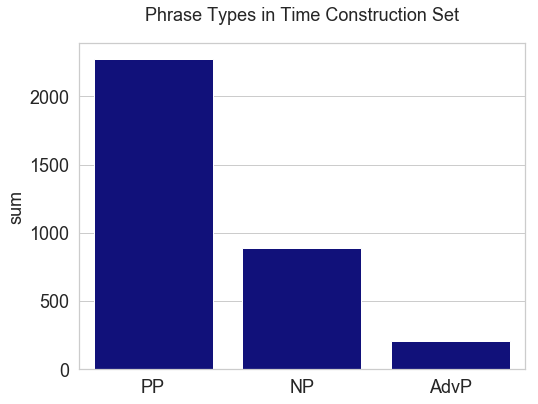

In [65]:
countBarplot(cx_types, title='Phrase Types in Time Construction Set')

There is a difference of 156% between the counts of NP and those of PP:

In [70]:
(cx_types.loc['PP']['sum'] - cx_types.loc['NP']['sum']) / cx_types.loc['NP']['sum']

1.5584269662921348

The preposition is the most influential form within time constructions.

### Preposition & Time Associations

I want to see whether certain prepositions are particularly associated with certain time nouns. A version of this analysis was done [SBH_time_expressions](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/SBH_time_expressions.ipynb) for Genesis-Kings. Here we do the analysis for the entire Hebrew Bible.

The association measure is the Fisher's exact test.

In [244]:
prep_obj_counts = collections.defaultdict(lambda: collections.Counter())
prep2obj2res = collections.defaultdict(lambda: collections.defaultdict(list))

for cx in F.otype.s('construction'):
    
    ph = L.d(cx, 'phrase')[0] # get first phrase
    
    if F.typ.v(ph) != 'PP':
        continue
            
    prep_chunk = next(obj for obj in L.d(cx, 'chunk') if F.label.v(obj) == 'prep') # get prep chunk
    prep_obj = E.obj_prep.t(L.d(prep_chunk, 'word')[-1])
    
    if prep_obj:
        prep_text = '.'.join(F.lex_utf8.v(w) for w in L.d(prep_chunk, 'word'))
        obj_text = F.lex_utf8.v(prep_obj[0])
        prep_obj_counts[prep_text][obj_text] += 1
        prep2obj2res[prep_text][obj_text].append(L.d(cx, 'phrase'))
        
prep_obj_counts = pd.DataFrame(prep_obj_counts).fillna(0)

In [245]:
prep_obj_counts.columnsCody

Index(['ב', 'ל', 'מן.קץ', 'מן.קצה', 'עד', 'אחר', 'כ', 'מן', 'בלת', 'ל.פנה',
       'כ.מן', 'ב.עוד', 'ב.אחרית', 'בין', 'את', 'עד.מן', 'ב.ראשׁ', 'ל.מן',
       'על', 'אל', 'ב.תוך', 'מן.ל', 'עד.בלת', 'ל.ראשׁ', 'מן.קצת', 'ל.קץ',
       'עד.ל', 'ל.פנה.מן', 'עד.אחר', 'ל.מן.ב'],
      dtype='object')

Apply the association test below. This will take some time...

In [246]:
po_assoc = apply_fishers(prep_obj_counts)

#### Attraction Plots

In [247]:
def assign_hue(iterable_data, p=1.3, maxvalue=10, minvalue=-10):
    '''
    Function to assign heat-map hues based 
    on a p-value midpoint and max/min attraction
    values.
    
    The following rules are used for making
    the colors:
    p = pvalue, i.e. significance level
    upper grey = p
    lower grey = -p
    starting red = p+0.1
    starting blue = -p-0.4
    max_red = max(dataset) if > p = hotmax
    max_blue = min(dataset) if < p = coldmax
    
    --output--
    1. a dataframe with values mapped to a unique color code
    2. a list of rgba colors that are aligned with the
       indices of the data
    '''
    
    maxvalue = int(maxvalue) # for max red
    minvalue = int(minvalue) # for max blue
        
    # assign ranges based on p values and red/blue/grey
    red_range = len(range(int(p), maxvalue+1))
    blue_range = len(range(int(p), abs(minvalue-1)))
        
    blues = sns.light_palette('blue', blue_range)
    reds = sns.light_palette('red', red_range)
    grey = sns.color_palette('Greys')[0]
    
    # assign colors based on p-value
    data = list()
    colorCount = collections.Counter()
    rgbs = list()
    for point in iterable_data:
        if point > p:
            rgb = reds[int(point)-1]
            color = 'red'
        elif point < -p:
            rgb = blues[abs(int(point))-1] 
            color = 'blue'
        else:
            rgb = grey
            color = 'grey'
            
        color_count = colorCount.get(color, 0)
        colorCount[color] += 1
        data.append([point, f'{color}{color_count}'])
        rgbs.append(rgb)
        
    data = pd.DataFrame(data, columns=('value', 'color'))
        
    return data, rgbs

In [277]:
# values for uniform hue assignment:
maxattraction = float(po_assoc.max().max())
minattraction = float(po_assoc.min().min())
pvalue = 1.3

def plot_attraction(prep, size=(15, 5)):
        
    # get plot data and generate hues
    colexs = po_assoc[prep].sort_values()    
    colex_data, colors = assign_hue(colexs.values, p=pvalue, maxvalue=maxattraction, minvalue=minattraction)
    
    # plot the figure
    plt.figure(figsize=size)
    dummyY = ['']*colexs.shape[0] # needed due to bug with Y & hue
    ax = sns.swarmplot(x=colex_data['value'], y=dummyY, hue=colex_data['color'], size=15, palette=colors)
    ax.legend_.remove()
        
     # offset annotation text from dot for readability
    offsetX, offsetY = np.array(ax.collections[0].get_offsets()).T
    
    plt.xlabel('attraction')
    plt.title(f'Time Attractions to {reverse_hb(prep)}')
    
    # annotate lexemes for those with significant values
    for i, prep in enumerate(colexs.index):  
        annotateX = offsetX[i]
        annotateY = offsetY[i] - 0.06
        prep_text = reverse_hb(prep).replace('/','').replace('=','')
        if colexs[prep] > pvalue:
            ax.annotate(prep_text, (annotateX, annotateY), size=16)
        elif colexs[prep] < -pvalue:
            ax.annotate(prep_text, (annotateX, annotateY), size=16)

In [278]:
pd.DataFrame(prep_obj_counts.sum().sort_values(ascending=False)).head(10)

,0
ב,1269.0
עד,314.0
ל,294.0
מן,155.0
אחר,51.0
כ,49.0
מן.קץ,19.0
ב.אחרית,15.0
ל.מן,14.0
ב.עוד,11.0


Let's look at everything up to כ by setting a count limit of > 20.

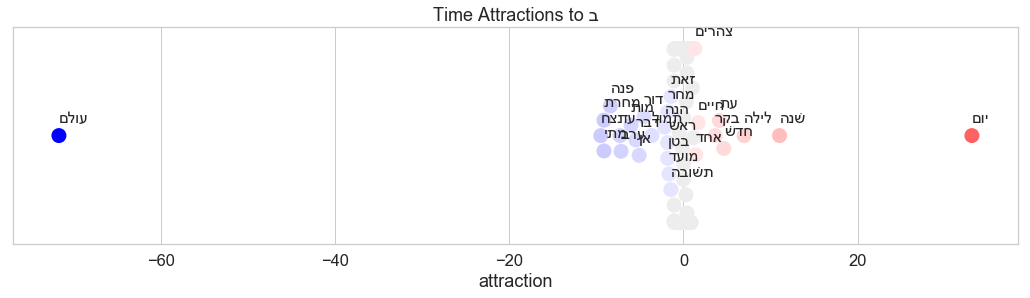

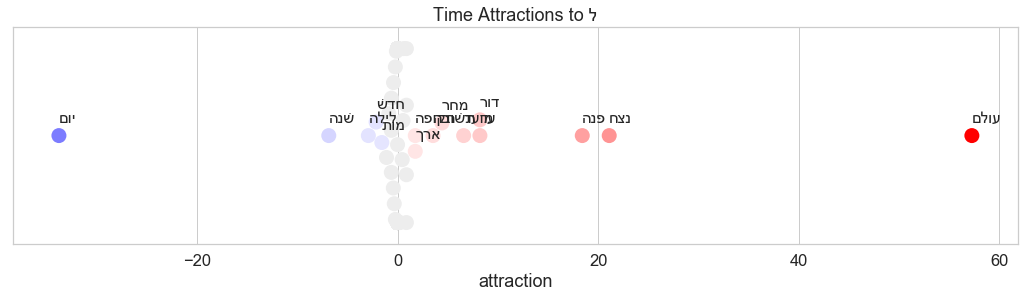

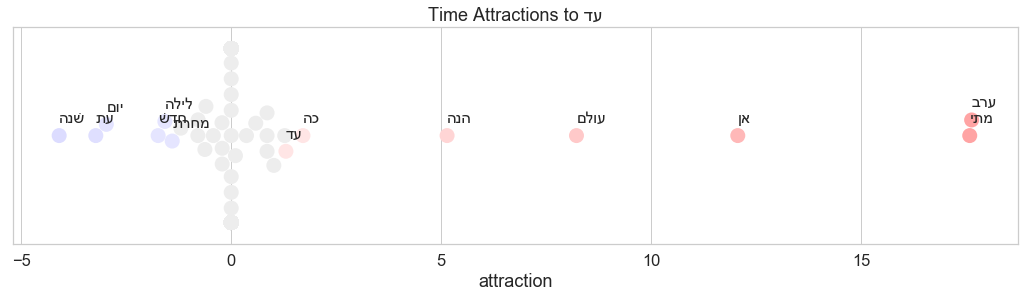

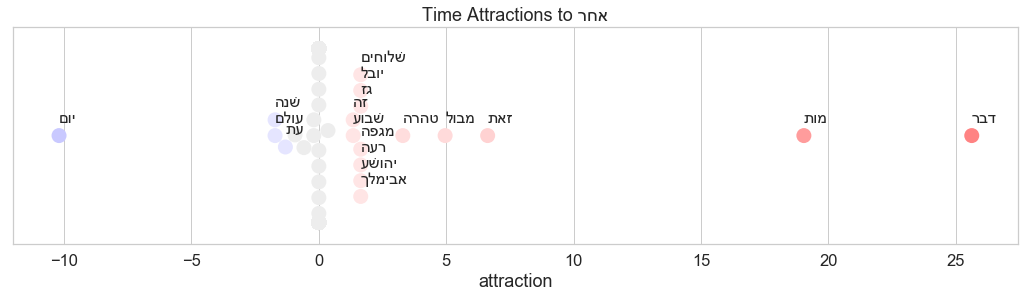

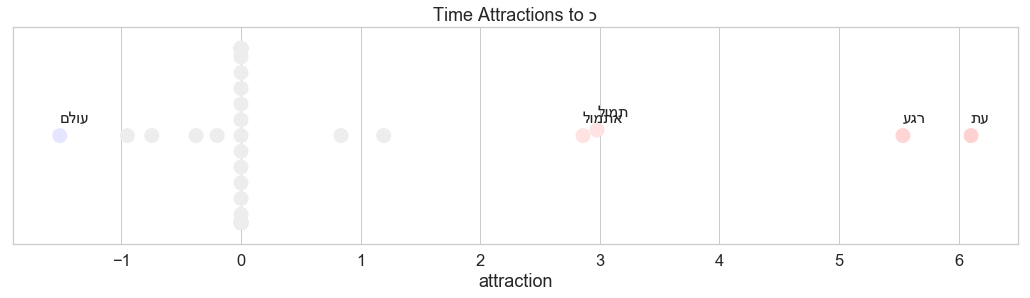

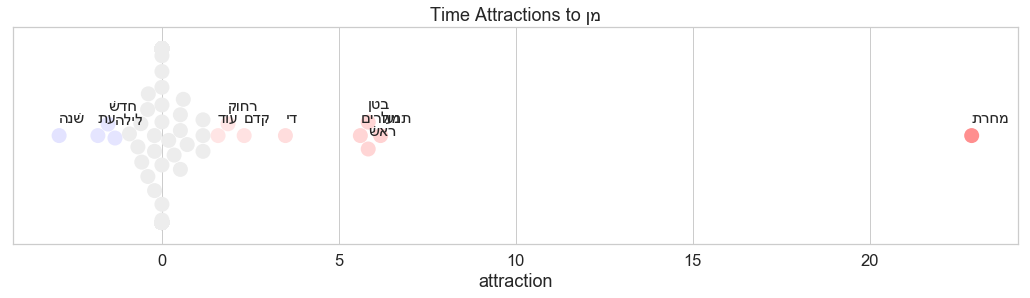

In [279]:
for prep in prep_obj_counts.columns[(prep_obj_counts.sum() > 20)]:
    plot_attraction(prep, size=(18, 4))

I can see that times which are attracted to ב are primarily calendrical times like "day", "year", "month", "morning", but also עת "time". The attraction between יום and ב is quite strong.

The ל preposition, as well as עד, prefers more deictic, adverbial kinds of indicators like לעולם, לצח, לפני, מחר. Indeed עד has nearly identical preferences. The association between ל and עולם is the strongest in the dataset:

In [285]:
print('top 5 association scores in dataset by their prep')
po_assoc.max().sort_values(ascending=False).head(5)

top 5 association scores in dataset by their prep


ל      57.257779
ב      33.105173
אחר    25.624868
מן     22.884897
עד     17.638229
dtype: float64

In [286]:
print('top 5 associations to ל')
po_assoc['ל'].sort_values(ascending=False).head(5)

top 5 associations to ל


עולם    57.257779
נצח     21.103473
פנה     18.416234
דור      8.212589
עד       8.212589
Name: ל, dtype: float64

This very strong score suggests the possibility that ל and עולם together constitute a strongly entrenched unit. Note also that the association between ל and נצח is likewise quite strong, as is the association with פנה. These smaller associations can be interpreted through the entrenched combination of ל+עולם.  

The preposition אחר has a distinct preference for nouns that are not necessary associated with time, such as proper names and nouns representing events. 

כ is attracted to עת, which is a notable similarity with ב. This is consistent with observations that these two prepositions have similar meanings. The use with תמול and אתמול are worth investigating. 

Finally, מן is primarily attracted to מחרת, a 

### Time Constructions, Clustered on Raw Surface Forms (tokens)

In this section, I break down time constructions by clustering them based on surface forms and various surface form filters. This is a rough form of clustering, by which two time constructions are grouped together if their tokenized strings match.

In [112]:
def surfaceToken(phrasenode):
    '''
    Return a surface token of a phrase node.
    The words are dot-separated and heh consonants
    are added if they are present in vocalized form. 
    '''
    subtokens = []
    for w in L.d(phrasenode, 'word'):
        if F.lex.v(w) == 'H':
            subtokens.append('ה')
        else:
            subtokens.append(F.g_cons_utf8.v(w))
    return '.'.join(subtokens)
    

freq_surface = collections.Counter()
for cx in F.otype.s('construction'):
    freq_surface[surfaceToken(cx)] += 1
freq_surface = convert2pandas(freq_surface)

In [114]:
freq_surface.head(20)

,sum
ב.ה.יום.ה.הוא,203
ה.יום,191
ל.עולם,85
ב.ה.בקר,78
עד.ה.יום.ה.זה,71
ב.יום,69
שׁבעת.ימים,63
עד.עולם,53
כל.ה.ימים,44
כל.ה.יום,42


ב.ה.יום.ה.הוא is a dominant pattern. But there are other patterns that are similar to it, such as עד.ה.יום.ה.זה or ב.ה.עת.ה.היא. Other similarities include ל.ֹעולם and עד.עולם. Taking a broader definition of similarity to include a role within the phrase, we can see similarities between the preposition + object constructions such as: ל.עולם, ב.יום, ל.נצח.

### Time Constructions, Clustered on Parts of Speech and Chunks

Based on the kinds of resemblances mentioned above, I wanted to obtain a clustering that better reflected word types and sub-constructions within the time constructions. A "sub-construction", what I have called "chunks", consist of either chained prepositional phrases: e.g. מקץ "from the end of...", or quantified noun phrases, which can consist of chained cardinal numbers such as שׁבעים ושׁשׁ שׁנה. These chunks were processed in [chunking](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/preprocessing/chunking.ipynb) and then further refined into complete tags in [time constructions [part 1]](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/time_constructions1.ipynb).

The result is a tokenization strategy which produces larger, more useful clusters. In fact, the top 11 of these clusters account for 76% of the entire dataset, as I show.

In [115]:
freq_times = collections.Counter()
for cx in F.otype.s('construction'):
    freq_times[F.label.v(cx)] += 1
freq_times = convert2pandas(freq_times)

In [116]:
freq_times.head(20)

,sum
prep.time,549
prep.H.time.H.dem,428
quantNP,325
prep.H.time,307
H.time,215
time,209
prep.time.adju,155
prep.H.time.H.ordn,147
qualQuant.H.time,100
prep.quantNP,63


Top 11 account for 76% of the dataset:

In [119]:
freq_times.head(11)['sum'].sum() / freq_times['sum'].sum()

0.7565165876777251

The top 20 account for 83% of the dataset:

In [120]:
freq_times.head(20)['sum'].sum() / freq_times['sum'].sum()

0.8311611374407583

It is my hunch that the remaining 25% / 17% of the data most often consists of some combination of the major types reflected in the top 75% group. Thus by describing and understanding these major types, we can obtain even better clustering parameters.

From this point forward I will focus on accounting for the subgroups found amongst these major clusters.

## `prep.time`

What kind of time nouns most often appear in the `time` slot?

In [191]:
pt_time = collections.Counter()
pt_prep = collections.Counter()
pt_cx = collections.Counter()

tag2res = collections.defaultdict(list)

for cx in set(F.otype.s('construction')) & set(F.label.s('prep.time')):
    time = next(role[0] for role in E.role.t(cx) if role[1]=='time')
    prep = next(role[0] for role in E.role.t(cx) if role[1]=='prep')
    time_text = F.lex_utf8.v(time)
    prep_text = '.'.join(F.lex_utf8.v(w) for w in L.d(prep, 'word'))
    cx_text = '.'.join(F.g_cons_utf8.v(w) for w in L.d(cx, 'word'))
    
    pt_time[time_text] += 1
    pt_prep[prep_text] += 1
    pt_cx[cx_text] += 1
    tag2res[cx_text].append(L.d(cx, 'phrase'))
    tag2res[time_text].append(L.d(cx, 'phrase'))
    tag2res[prep_text].append(L.d(cx, 'phrase'))
    
pt_time = convert2pandas(pt_time)
pt_prep = convert2pandas(pt_prep)
pt_cx = convert2pandas(pt_cx)

#### Top Raw Surface Form Counts

In [192]:
pt_cx.head(20)

,sum
ל.עולם,85
ב.יום,69
עד.עולם,53
ל.נצח,24
עד.מתי,23
מ.מחרת,19
ל.פנים,15
ל.עלם,15
ב.ימיו,13
עד.אנה,13


#### Top Times

In [186]:
pt_time.head(20)

,sum
עולם,163
יום,119
עת,30
נצח,25
מתי,25
פנה,22
מחרת,19
עד,18
אן,14
בקר,11


#### Top Preposition Counts

In [181]:
pt_prep

,sum
ל,176
ב,136
עד,132
מן,63
אחר,12
ל.פנה,5
ל.מן,4
כ,4
ל.קץ,3
עד.ל,2


Does עולם ever have additional modifications? I know from previous analysis of time constructions that they often have various morphological modifications or additional specifications. I would expect this to be different with עולם, and I would also expect this situation to resemble other words that are being used adverbially. If there is indeed a strict separation between patterns with and without these kinds of modifications, I may have good reason to define this as an "adverb construction," i.e. a construction with deictic sense and that caries its temporal modifications internally. 

Practically it makes more sense to first define what I mean, especially in terms of database querying, of "modifications." In order to do that, I move on to the next most common item in the list, יום. I know from the previous analysis that יום *does* in fact attract these modifications. By definining them here, I might have a way to identify other cases that have such modifications. Then I can define those without modifications as the inverse of these search parameters.

**Below are a few examples of יום as used with a preposition.** The examples are shown in the context of a sentence, because infinitival modifiers of יום will exist occur as clauses embedded in the same sentence. These cases in particular are marked with a clause relation of `RgRc` (Regens/rectum connection). Note that I have collapsed the cases with `end=1`. Modify this to see all the other examples. 

In [292]:
A.show(tag2res['יום'], condenseType='sentence', extraFeatures='st vt', end=1) # <- NB modify end= to see more than 5 examples

After reviewing several dozen cases, I see 4 specific patterns that follow the construction ב+יום:

* \+ [CONSTRUCT] + [VERBAL CLAUSE rela=RgRc] (often with infinitive but occasionally with qatal)
* \+ [PLURAL ENDING]
* \+ [PRONOMINAL SUFFIX]
* \+ [אשׁר in VERBAL CLAUSE rela=Attr]

Let's see how much of the יום pattern this accounts for. The individual cases are stored under `tag2res['יום']`. We define a few search patterns to account for the cases above. The phrases stored in `tag2res` are fed in as sets so that only those cases are queried.

In [326]:
yom_phrases = set(phrase for res in tag2res['יום'] for phrase in res)
found_yom = set()

print(len(yom_phrases), 'total יום phrases')

# + CONSTRUCT + VERBAL CLAUSE
verbal_construct = set(res[1] for res in A.search('''

sentence
    yomphrase
        word lex=JWM/
        /with/
        <mother- clause rela=RgRc kind=VC
        /or/
        y1:yomphrase
            ..
        c1:clause rela=Attr
        y1 <mother- c1
        /-/

''', sets={'yomphrase': yom_phrases}, silent=True))
found_yom |= (verbal_construct)

print(f'verbal construct cases found: {len(verbal_construct)}')


# + PLURAL
pluralday = set(res[1] for res in A.search('''

sentence
    yomphrase
        word lex=JWM/ nu=pl

''', sets={'yomphrase': yom_phrases}, silent=True))
found_yom |= (pluralday)

print(f'plural cases found: {len(pluralday)}')

# + PRONOMINAL 
pronominalday = set(res[1] for res in A.search('''

sentence
    yomphrase
        word lex=JWM/ prs#absent

''', sets={'yomphrase': yom_phrases}, silent=True))
found_yom |= (pronominalday)
print(f'pronominal suffix cases found: {len(pronominalday)}')

# + אשׁר/relative + VERBAL CLAUSE 
asher_day = set(res[1] for res in A.search('''

sentence
        yomphrase
            word lex=JWM/
            /with/
            sentence
                ..
                <: clause rela=Attr
                    =: phrase function=Rela
            /-/

''', sets={'yomphrase': yom_phrases}, silent=True))
found_yom |= (asher_day)
print(f'relative attributive cases found: {len(asher_day)}')

print(f'remaining cases: {len(yom_phrases-found_yom)}')

119 total יום phrases
verbal construct cases found: 87
plural cases found: 29
pronominal suffix cases found: 22
relative attributive cases found: 4
remaining cases: 5


Let's look at the 5 remaining cases...

In [333]:
#A.show([(case,) for case in yom_phrases-found_yom], extraFeatures='st nu', condenseType='sentence') # uncomment to see cases

The remaining cases are all interesting, especially Psalm 138:3 and Ruth 4:5. These may be true cases of non-modification, **construing יום as an adverb.** The case of Ezra 3:4 does not look like an adverbial use of the time construction. I will consider removing it from the samples moving forward. 

There is one important case that I did not account for at first: the dual ending. I added that below.

In [331]:
# + PLURALCody
dualday = set(res[1] for res in A.search('''

sentence
    yomphrase
        word lex=JWM/ nu=du

''', sets={'yomphrase': yom_phrases}, silent=True))
found_yom |= (dualday)

print(f'dual cases found: {len(dualday)}')

dual cases found: 1


Below this final case is added to the others, bringing the total construction forms to 5:

* \+ [CONSTRUCT] + [VERBAL CLAUSE rela=RgRc | occasionally Attr in BHSA] (often with infinitive but occasionally with qatal)
* \+ [PLURAL ENDING]
* \+ [PRONOMINAL SUFFIX]
* \+ [אשׁר in VERBAL CLAUSE rela=Attr]
* \+ [DUAL ENDING]

**Based on these features, I propose to attempt a two-way subdivision of all constructions in the `prep.time` construction: 1) those that appear with specification, and 2) those that appear without specification.** I will test the efficacy of this division below with a handcoded version of the templates from above. 

The specified times will go into `cx_specified` mapped to the form that they were found in.

In [370]:
cx_specified = collections.defaultdict(list)
lex2tag2result = collections.defaultdict(lambda: collections.defaultdict(list)) # keep a mapping from time lexemes to their specific results 

for cx in set(F.otype.s('construction')) & set(F.label.s('prep.time')):
    
    phrase = L.d(cx, 'phrase')[0]
    time = next(role[0] for role in E.role.t(cx) if role[1]=='time')
    time_mother = [cl for cl in E.mother.t(time) if F.rela.v(cl) == 'RgRc']
    phrase_mother = [cl for cl in E.mother.t(phrase) if F.rela.v(cl) == 'Attr']
    result = (phrase, time)
    
    # isolate construct + verbal clauses
    if time_mother:
        tag = 'construct + VC'  
        
    # isolate plural endings
    elif F.nu.v(time) == 'pl':
        tag = 'plural'
        
    # isolate relative clauses | attributives
    elif phrase_mother:
        if 'Rela' in set(F.function.v(ph) for ph in L.d(phrase_mother[0], 'phrase')):
            tag = 'RELA + VC'
        else:
            tag = '+ VC'
        
    # isolate pronominal suffixes
    elif F.prs.v(time) not in {'absent', 'n/a'}:
        tag = 'pronominal suffix'
        
    # isolate dual endings
    elif F.nu.v(time) == 'du':
        tag = 'dual'
        
    else:
        tag = None
        
    if tag:
        cx_specified[tag].append(result)
        lex2tag2result[F.lex_utf8.v(time)][tag].append(result)
        
cx_specified_all = set(res for tag in cx_specified for res in cx_specified[tag])
        
found = len(set(res[0] for res in cx_specified_all))

print(f'number found {found} ({found / pt_cx["sum"].sum()})')

number found 218 (0.3970856102003643)


These patterns thus account for 40% of the cases in this construction. That is a good discrimination rate.

In [371]:
#A.show(cx_specified['construct + VC'], condenseType='sentence', extraFeatures='st')

Let's see what lexemes those accounted for...

In [372]:
lex_count = collections.Counter()

for phrase, time in cx_specified_all:
    lex_count[F.lex_utf8.v(time)] += 1
    
lex_count = convert2pandas(lex_count)

lex_count

,sum
יום,115
עת,27
פנה,22
מות,10
חיים,6
נעורים,6
דור,4
עוד,2
אחרית,2
מועד,2


In [385]:
lex2tag2result['נעורים']

defaultdict(list,
            {'plural': [(737983, 151525),
              (761328, 190579),
              (784878, 228724),
              (784921, 228781),
              (813928, 275743),
              (813990, 275826)]})

In [386]:
A.show(lex2tag2result['נעורים']['plural'])

Many of these lexemes are quite similar to יום in terms of being calendrical or having similar prepositional preferences.

Below are lexemes that were not found.

In [389]:
not_specified = []

spec_set = set(res[0] for res in cx_specified_all)

for cx in set(F.otype.s('construction')) & set(F.label.s('prep.time')):
    
    phrase = L.d(cx, 'phrase')[0]
    
    if phrase not in spec_set:
        time = next(role[0] for role in E.role.t(cx) if role[1]=='time')
        result = (phrase, time)
        not_specified.append(result)
        
print(len(not_specified))

331


In [390]:
lex_count2 = collections.Counter()

for phrase, time in not_specified:
    lex_count2[F.lex_utf8.v(time)] += 1
    
lex_count2 = convert2pandas(lex_count2)

lex_count2

,sum
עולם,162
נצח,25
מתי,25
מחרת,19
עד,18
אן,14
בקר,11
הנה,6
יום,4
מחר,4


This is a strong list of adverbial forms. There are also several nouns mixed in. Note the appearance of יומם as well, which is a great example of a nominal form that is slotted as an adverbial—in this case that is obvious because of the adverbial ending that is appended to it.

**The cases above, as they are not modified, are anchored either to discourse context or the time of speech.** It would be interesting to isolate when the reference is discourse-anchored. For example, the case of proper names this would be relatively easy to ascertain. However, most of these seem to be anchored to speech time.

In [396]:
A.show(tag2res['זאת'], extraFeatures='prs')

This case ^ is a good example, though, of a discourse-anchored form.